# 만들어진 Doc2Vec model을 통한 감정분석 실시
> * Positive or Negative

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

C:\Users\pc\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14048921442799603239
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4984510873
locality {
  bus_id: 1
}
incarnation: 8209804069221882552
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3, model4):
    print ('Logistic Regression')
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    print ('Random Forest')
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    print ('Kernel SVM')
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    print ('XGBoost')
    import xgboost as xgb
    fpr4, tpr4, thresholds4 = roc_curve(y, model4.predict(xgb.DMatrix(x)))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.plot(fpr4, tpr4, label='XGBoost')
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
import gensim
gensim.__version__

'3.3.0'

* windows에서 모델을 만들때 사용한 gensim의 버전이 3.3이었고, mac에서는 버전이 맞지 않아서 만들어둔 모델을 불러오지 못하였음.

## Doc2Vec

In [6]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags sentiment')

In [7]:
def Get_Infer_Vector(docs, model):
    return [model.infer_vector(doc.words) for doc in tqdm(docs)]

In [8]:
if sys.platform =='darwin':
    loadModelPath = '/Volumes/disk1/model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

In [9]:
cores = int(multiprocessing.cpu_count() )
print (cores)

12


### twitter

#### Load Model

In [10]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

#### Word to Vector

##### train set

In [11]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_ct_train_for_doc2vec_sentiment_analysis.pickled','rb'))

In [12]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis'):
    train_senti_y = [doc.sentiment for doc in tqdm(train)]
    
    pickle.dump(train_senti_y, open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','wb'))
    del train_senti_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_ct_for_sentiment_analysis'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_ct_for_sentiment_analysis','wb'))
    del train_tags_y

if 'train' in locals():
    del train

##### test set

In [13]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_ct_test_for_doc2vec_sentiment_analysis.pickled','rb'))

In [14]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis'):
    test_senti_y = [doc.sentiment for doc in tqdm(test)]
    
    pickle.dump(test_senti_y, open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','wb'))
    del test_senti_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_ct_for_sentiment_analysis'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_ct_for_sentiment_analysis','wb'))
    del test_tags_y

if 'test' in locals():
    del test

#### model1
* Doc2Vec(dm/m,d1000,n7,w10,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [15]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','rb'))

In [16]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [17]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

100%|██████████| 49151/49151 [00:00<00:00, 1752803.54it/s]


In [18]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.6916034261764765
classification report
             precision    recall  f1-score   support

          0       0.71      0.67      0.69     25177
          1       0.67      0.71      0.69     23974

avg / total       0.69      0.69      0.69     49151

Wall time: 11min 9s


In [19]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [20]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6223271144025554
classification report
             precision    recall  f1-score   support

          0       0.62      0.66      0.64     25177
          1       0.62      0.58      0.60     23974

avg / total       0.62      0.62      0.62     49151

Wall time: 6min 35s


In [21]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [22]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m1)
train_x_by_m1_2 = scaling.transform(train_x_by_m1)
test_x_by_m1_2 = scaling.transform(test_x_by_m1)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1_2)))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.5691033753128115
classification report
             precision    recall  f1-score   support

          0       0.76      0.23      0.35     25177
          1       0.53      0.93      0.68     23974

avg / total       0.65      0.57      0.51     49151

Wall time: 23min 51s


In [23]:
del scaling
del train_x_by_m1_2
del test_x_by_m1_2

In [24]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : XGBOOST

In [25]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

442359it [00:00, 461432.36it/s]
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
49151it [00:00, 614206.87it/s]


Wall time: 7.33 s


In [26]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

Wall time: 7.4 s


In [27]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.125,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620383	eval-auc:0.624273
[2]	train-auc:0.629441	eval-auc:0.63416
[3]	train-auc:0.636825	eval-auc:0.641988
[4]	train-auc:0.639517	eval-auc:0.644154
[5]	train-auc:0.64336	eval-auc:0.64685
[6]	train-auc:0.648082	eval-auc:0.651772
[7]	train-auc:0.649909	eval-auc:0.653717
[8]	train-auc:0.653058	eval-auc:0.656866
[9]	train-auc:0.656499	eval-auc:0.660032
[10]	train-auc:0.65983	eval-auc:0.66344
[11]	train-auc:0.662878	eval-auc:0.666622
[12]	train-auc:0.665189	eval-auc:0.668617
[13]	train-auc:0.667632	eval-auc:0.671249
[14]	train-auc:0.672056	eval-auc:0.675467
[15]	train-auc:0.674435	eval-auc:0.677681
[16]	train-auc:0.676552	eval-auc:0.679851
[17]	train-auc:0.678983	eval-auc:0.681274
[18]	train-auc:0.681106	eval-auc:0.683929
[19]	train-auc:0.683475	eval-auc:0.685759
[20]	train-auc:0.685404	eval-auc:0

[191]	train-auc:0.79073	eval-auc:0.772233
[192]	train-auc:0.79104	eval-auc:0.772459
[193]	train-auc:0.791178	eval-auc:0.772469
[194]	train-auc:0.791385	eval-auc:0.772594
[195]	train-auc:0.791704	eval-auc:0.772756
[196]	train-auc:0.792013	eval-auc:0.772951
[197]	train-auc:0.792223	eval-auc:0.773116
[198]	train-auc:0.79255	eval-auc:0.7733
[199]	train-auc:0.792752	eval-auc:0.773341
0.6881446969542837
Wall time: 8min 50s


Logistic Regression
Random Forest
Kernel SVM
XGBoost


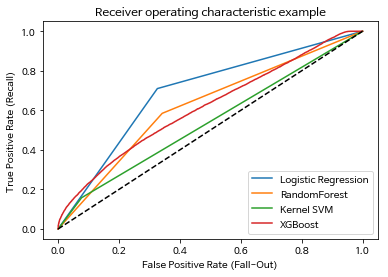

Wall time: 2min 26s


In [28]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 :  Neural Network

In [30]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5222
Accuracy: 0.7104


In [31]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

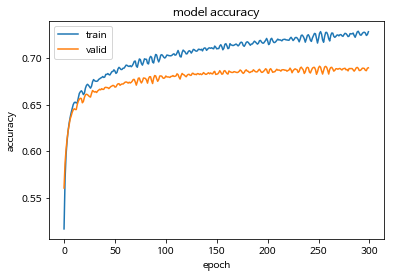

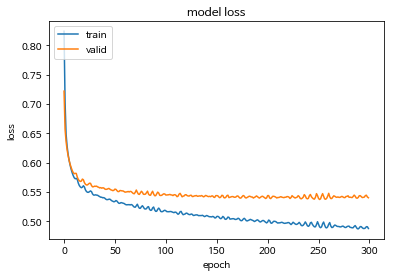

In [32]:
plot_history(history)

In [33]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5467
Accuracy: 0.7059


In [34]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

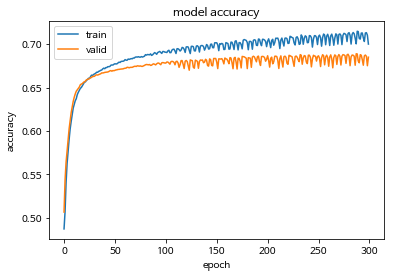

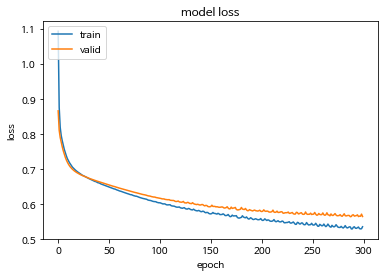

In [35]:
plot_history(history)

In [36]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d1000,n7,w5,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [37]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','rb'))

In [38]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','rb'))

In [39]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

100%|██████████| 49151/49151 [00:00<00:00, 1752192.73it/s]


#### 분류 모델 : Logistic Regression

In [40]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.5074566132937275
classification report
             precision    recall  f1-score   support

          0       0.51      0.95      0.66     25177
          1       0.45      0.05      0.08     23974

avg / total       0.48      0.51      0.38     49151

Wall time: 26min 5s


In [41]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [42]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.5312608085288194
classification report
             precision    recall  f1-score   support

          0       0.54      0.53      0.54     25177
          1       0.52      0.53      0.53     23974

avg / total       0.53      0.53      0.53     49151

Wall time: 9min 22s


In [43]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [44]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m2)
train_x_by_m2_2 = scaling.transform(train_x_by_m2)
test_x_by_m2_2 = scaling.transform(test_x_by_m2)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2_2)))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.48957294866838924
classification report
             precision    recall  f1-score   support

          0       0.61      0.01      0.02     25177
          1       0.49      0.99      0.65     23974

avg / total       0.55      0.49      0.33     49151

Wall time: 8min 46s


In [45]:
del scaling
del train_x_by_m2_2
del test_x_by_m2_2

In [46]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : XGBOOST

In [47]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

442359it [00:08, 49450.30it/s]
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
49151it [00:00, 522671.63it/s]


Wall time: 23.8 s


In [48]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

Wall time: 6.83 s


In [49]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.125,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m2_name)

[0]	train-auc:0.551102	eval-auc:0.552167
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.554097	eval-auc:0.554799
[2]	train-auc:0.555049	eval-auc:0.555529
[3]	train-auc:0.557052	eval-auc:0.557762
[4]	train-auc:0.557387	eval-auc:0.557806
[5]	train-auc:0.557809	eval-auc:0.557569
[6]	train-auc:0.558184	eval-auc:0.557579
[7]	train-auc:0.558783	eval-auc:0.558914
[8]	train-auc:0.558946	eval-auc:0.558934
[9]	train-auc:0.559766	eval-auc:0.558546
[10]	train-auc:0.561161	eval-auc:0.556688
[11]	train-auc:0.561692	eval-auc:0.557011
[12]	train-auc:0.561797	eval-auc:0.557932
[13]	train-auc:0.562785	eval-auc:0.557152
[14]	train-auc:0.563514	eval-auc:0.556364
[15]	train-auc:0.563838	eval-auc:0.556327
[16]	train-auc:0.564366	eval-auc:0.556988
[17]	train-auc:0.565085	eval-auc:0.556595
[18]	train-auc:0.565722	eval-auc:0.556751
Stopping. Best iteration:
[8]	train-auc:0.558946	eval-auc:0.558934

0.5

Logistic Regression
Random Forest
Kernel SVM
XGBoost


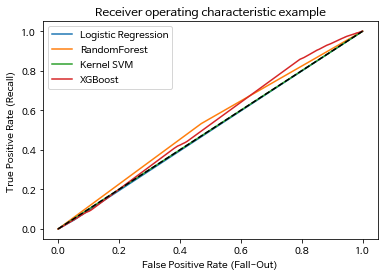

Wall time: 1min 23s


In [50]:
%%time
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3, gbm)

In [51]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [52]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6916
Accuracy: 0.5376


In [53]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

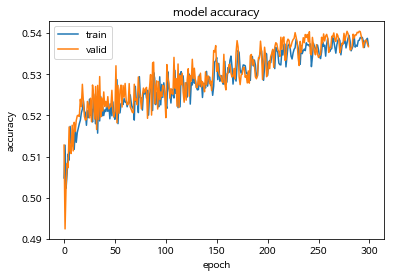

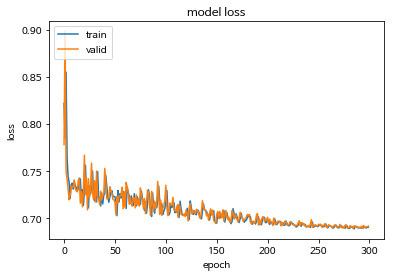

In [54]:
plot_history(history)

In [55]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6980
Accuracy: 0.5444


In [56]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

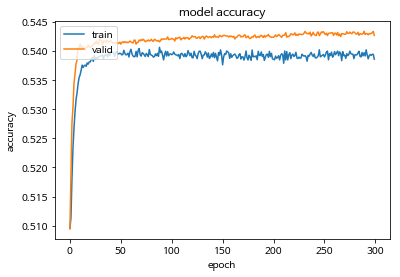

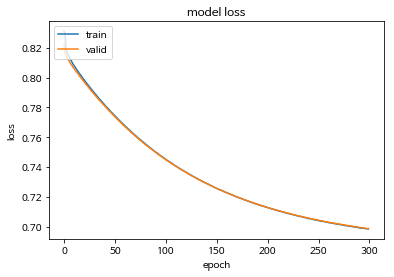

In [57]:
plot_history(history)

In [58]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

#### model3
* Doc2Vec(dbow,d1000,n7,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [59]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-ct'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','rb'))

In [60]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-ct'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','rb'))

In [61]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

100%|██████████| 49151/49151 [00:00<00:00, 1692368.99it/s]


#### 분류 모델 : Logistic Regression

In [62]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8265752477060487
classification report
             precision    recall  f1-score   support

          0       0.83      0.83      0.83     25177
          1       0.82      0.83      0.82     23974

avg / total       0.83      0.83      0.83     49151

Wall time: 10min 10s


In [63]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [65]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.7405139264714858
classification report
             precision    recall  f1-score   support

          0       0.73      0.78      0.75     25177
          1       0.75      0.70      0.73     23974

avg / total       0.74      0.74      0.74     49151

Wall time: 4min 50s


In [66]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [67]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m3)
train_x_by_m3_2 = scaling.transform(train_x_by_m3)
test_x_by_m3_2 = scaling.transform(test_x_by_m3)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3_2)))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.6093873980183516
classification report
             precision    recall  f1-score   support

          0       0.82      0.31      0.45     25177
          1       0.56      0.93      0.70     23974

avg / total       0.69      0.61      0.57     49151

Wall time: 26min 24s


In [68]:
del scaling
del train_x_by_m3_2
del test_x_by_m3_2

In [69]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : XGBOOST

In [70]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

442359it [00:02, 148802.65it/s]
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
49151it [00:00, 458666.85it/s]


Wall time: 11.6 s


In [71]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

Wall time: 7.27 s


In [72]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.125,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m3_name)

[0]	train-auc:0.656758	eval-auc:0.652557
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.701514	eval-auc:0.698299
[2]	train-auc:0.717162	eval-auc:0.713723
[3]	train-auc:0.735796	eval-auc:0.731943
[4]	train-auc:0.744426	eval-auc:0.739227
[5]	train-auc:0.749106	eval-auc:0.743804
[6]	train-auc:0.75519	eval-auc:0.750328
[7]	train-auc:0.762236	eval-auc:0.757715
[8]	train-auc:0.765335	eval-auc:0.760668
[9]	train-auc:0.771576	eval-auc:0.766599
[10]	train-auc:0.776279	eval-auc:0.771636
[11]	train-auc:0.779612	eval-auc:0.775177
[12]	train-auc:0.783353	eval-auc:0.778809
[13]	train-auc:0.787348	eval-auc:0.782533
[14]	train-auc:0.791368	eval-auc:0.786807
[15]	train-auc:0.794895	eval-auc:0.789878
[16]	train-auc:0.797552	eval-auc:0.792459
[17]	train-auc:0.800958	eval-auc:0.796025
[18]	train-auc:0.804419	eval-auc:0.799519
[19]	train-auc:0.807092	eval-auc:0.802207
[20]	train-auc:0.810197	eval-a

[191]	train-auc:0.909291	eval-auc:0.8929
[192]	train-auc:0.909484	eval-auc:0.893079
[193]	train-auc:0.909634	eval-auc:0.893193
[194]	train-auc:0.909803	eval-auc:0.893304
[195]	train-auc:0.91	eval-auc:0.893459
[196]	train-auc:0.9102	eval-auc:0.893581
[197]	train-auc:0.910388	eval-auc:0.893726
[198]	train-auc:0.910598	eval-auc:0.893864
[199]	train-auc:0.910779	eval-auc:0.893976
0.8086712376146976
Wall time: 9min 1s


Logistic Regression
Random Forest
Kernel SVM
XGBoost


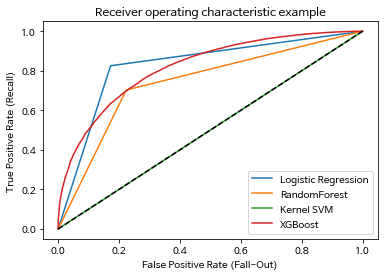

Wall time: 2min 56s


In [73]:
%%time
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3, gbm)

In [74]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [75]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.3423
Accuracy: 0.8474


In [76]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

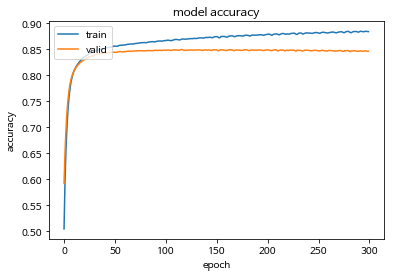

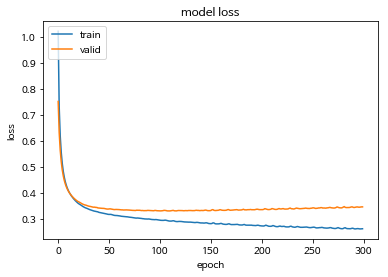

In [77]:
plot_history(history)

In [78]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.3625
Accuracy: 0.8481


In [79]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

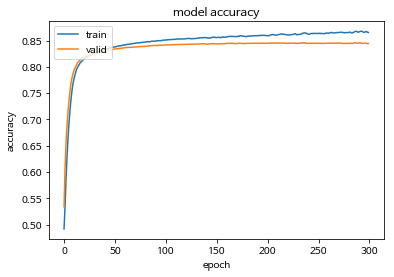

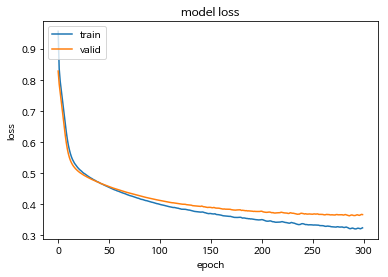

In [80]:
plot_history(history)

In [81]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name

#### mecab

#### Load Model

In [10]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

#### Word to Vector

##### train set

In [11]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_mecab_train_for_doc2vec_sentiment_analysis.pickled','rb'))

In [12]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis'):
    train_senti_y = [doc.sentiment for doc in tqdm(train)]
    
    pickle.dump(train_senti_y, open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','wb'))
    del train_senti_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_mecab_for_sentiment_analysis'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_mecab_for_sentiment_analysis','wb'))
    del train_tags_y

if 'train' in locals():
    del train

##### test set

In [13]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_mecab_test_for_doc2vec_sentiment_analysis.pickled','rb'))

In [14]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis'):
    test_senti_y = [doc.sentiment for doc in tqdm(test)]
    
    pickle.dump(test_senti_y, open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','wb'))
    del test_senti_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_mecab_for_sentiment_analysis'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_mecab_for_sentiment_analysis','wb'))
    del test_tags_y

if 'test' in locals():
    del test

#### model1
* Doc2Vec(dm/m,d1000,n7,w10,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [15]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','rb'))

In [16]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-mecab'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [17]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

100%|██████████| 49151/49151 [00:00<00:00, 1692341.20it/s]


In [18]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7035258692600354
classification report
             precision    recall  f1-score   support

          0       0.72      0.69      0.70     25177
          1       0.69      0.72      0.70     23974

avg / total       0.70      0.70      0.70     49151

Wall time: 2min


In [19]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [20]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6351244125246689
classification report
             precision    recall  f1-score   support

          0       0.64      0.65      0.64     25177
          1       0.63      0.62      0.63     23974

avg / total       0.64      0.64      0.64     49151

Wall time: 6min 20s


In [21]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [22]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m1)
train_x_by_m1_2 = scaling.transform(train_x_by_m1)
test_x_by_m1_2 = scaling.transform(test_x_by_m1)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1_2)))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.5731114321173526
classification report
             precision    recall  f1-score   support

          0       0.86      0.20      0.32     25177
          1       0.53      0.97      0.69     23974

avg / total       0.70      0.57      0.50     49151

Wall time: 25min 2s


In [23]:
del scaling
del train_x_by_m1_2
del test_x_by_m1_2

In [24]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : XGBOOST

In [25]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

442359it [00:01, 378162.58it/s]
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
49151it [00:00, 701095.19it/s]


Wall time: 7.21 s


In [26]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

Wall time: 6.89 s


In [27]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.125,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m1_name)

[0]	train-auc:0.611005	eval-auc:0.614605
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.628688	eval-auc:0.634104
[2]	train-auc:0.637132	eval-auc:0.64182
[3]	train-auc:0.646093	eval-auc:0.650755
[4]	train-auc:0.651118	eval-auc:0.65404
[5]	train-auc:0.653561	eval-auc:0.656101
[6]	train-auc:0.657846	eval-auc:0.660183
[7]	train-auc:0.664717	eval-auc:0.667411
[8]	train-auc:0.667881	eval-auc:0.670555
[9]	train-auc:0.672127	eval-auc:0.673759
[10]	train-auc:0.675639	eval-auc:0.676782
[11]	train-auc:0.679415	eval-auc:0.681317
[12]	train-auc:0.682874	eval-auc:0.684858
[13]	train-auc:0.685739	eval-auc:0.687456
[14]	train-auc:0.6878	eval-auc:0.689437
[15]	train-auc:0.690554	eval-auc:0.691879
[16]	train-auc:0.692536	eval-auc:0.693439
[17]	train-auc:0.695037	eval-auc:0.694987
[18]	train-auc:0.697697	eval-auc:0.697507
[19]	train-auc:0.700023	eval-auc:0.699445
[20]	train-auc:0.702028	eval-auc:

[191]	train-auc:0.810033	eval-auc:0.788249
[192]	train-auc:0.810237	eval-auc:0.788385
[193]	train-auc:0.810549	eval-auc:0.788664
[194]	train-auc:0.810659	eval-auc:0.788674
[195]	train-auc:0.810954	eval-auc:0.788764
[196]	train-auc:0.811288	eval-auc:0.789032
[197]	train-auc:0.811537	eval-auc:0.789212
[198]	train-auc:0.811774	eval-auc:0.789375
[199]	train-auc:0.811916	eval-auc:0.789495
0.6983988118247848
Wall time: 8min 45s


Logistic Regression
Random Forest
Kernel SVM
XGBoost


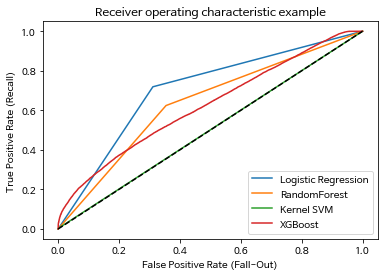

Wall time: 2min 34s


In [28]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [30]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.4955
Accuracy: 0.7290


In [31]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

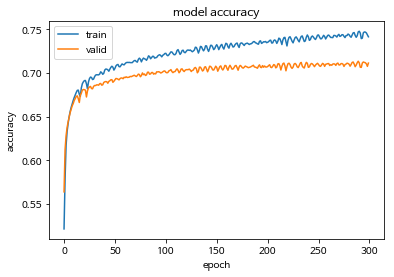

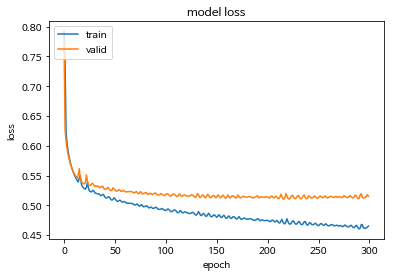

In [32]:
plot_history(history)

In [33]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5187
Accuracy: 0.7280


In [34]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

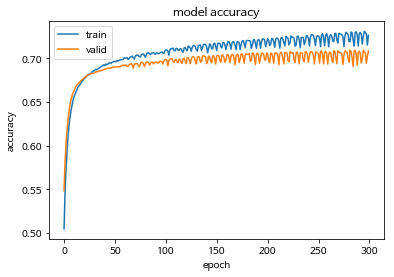

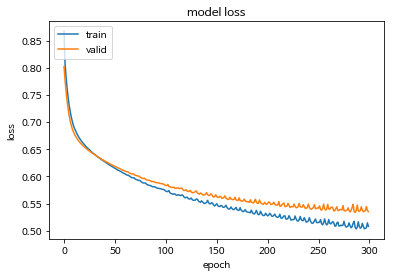

In [35]:
plot_history(history)

In [36]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d1000,n7,w5,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [37]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','rb'))

In [38]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','rb'))

In [39]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

100%|██████████| 49151/49151 [00:00<00:00, 1692327.31it/s]


#### 분류 모델 : Logistic Regression

In [40]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.5083111228662692
classification report
             precision    recall  f1-score   support

          0       0.51      0.96      0.67     25177
          1       0.45      0.03      0.06     23974

avg / total       0.48      0.51      0.37     49151

Wall time: 9min 58s


In [41]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [42]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.5354316290614637
classification report
             precision    recall  f1-score   support

          0       0.55      0.54      0.54     25177
          1       0.52      0.53      0.53     23974

avg / total       0.54      0.54      0.54     49151

Wall time: 12min 30s


In [43]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [44]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m2)
train_x_by_m2_2 = scaling.transform(train_x_by_m2)
test_x_by_m2_2 = scaling.transform(test_x_by_m2)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2_2)))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.4886370572317959
classification report
             precision    recall  f1-score   support

          0       0.68      0.00      0.01     25177
          1       0.49      1.00      0.66     23974

avg / total       0.59      0.49      0.32     49151

Wall time: 8min 55s


In [45]:
del scaling
del train_x_by_m2_2
del test_x_by_m2_2

In [46]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : XGBOOST

In [47]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

442359it [00:11, 37447.27it/s]
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
49151it [00:00, 621303.93it/s]


Wall time: 28.3 s


In [48]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

Wall time: 7.93 s


In [49]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.125,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m2_name)

[0]	train-auc:0.552275	eval-auc:0.550363
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.55495	eval-auc:0.552752
[2]	train-auc:0.556162	eval-auc:0.554401
[3]	train-auc:0.556538	eval-auc:0.554761
[4]	train-auc:0.557451	eval-auc:0.555702
[5]	train-auc:0.559414	eval-auc:0.556277
[6]	train-auc:0.559515	eval-auc:0.556416
[7]	train-auc:0.560661	eval-auc:0.556784
[8]	train-auc:0.561071	eval-auc:0.557399
[9]	train-auc:0.561588	eval-auc:0.556314
[10]	train-auc:0.562198	eval-auc:0.556272
[11]	train-auc:0.563118	eval-auc:0.555958
[12]	train-auc:0.563987	eval-auc:0.555867
[13]	train-auc:0.564819	eval-auc:0.556446
[14]	train-auc:0.566062	eval-auc:0.556264
[15]	train-auc:0.566535	eval-auc:0.556159
[16]	train-auc:0.567027	eval-auc:0.556167
[17]	train-auc:0.567841	eval-auc:0.556803
[18]	train-auc:0.568662	eval-auc:0.557261
Stopping. Best iteration:
[8]	train-auc:0.561071	eval-auc:0.557399

0.54

Logistic Regression
Random Forest
Kernel SVM
XGBoost


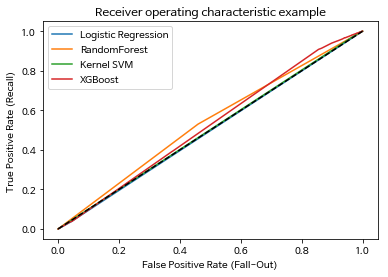

Wall time: 1min 25s


In [50]:
%%time
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3, gbm)

In [51]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [52]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6911
Accuracy: 0.5405


In [53]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

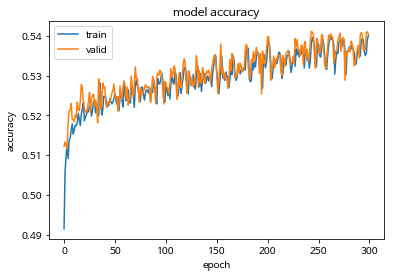

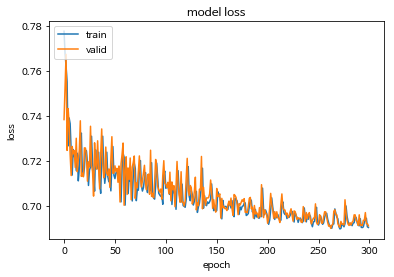

In [54]:
plot_history(history)

In [55]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6996
Accuracy: 0.5421


In [56]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

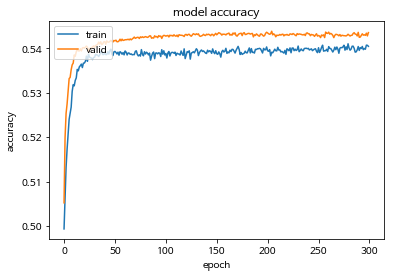

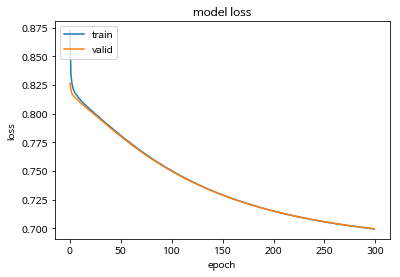

In [57]:
plot_history(history)

In [58]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name


#### model3
* Doc2Vec(dbow,d1000,n7,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [82]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-mecab'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','rb'))

In [83]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-mecab'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','rb'))

In [84]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

100%|██████████| 49151/49151 [00:00<00:00, 1583061.90it/s]


#### 분류 모델 : Logistic Regression

In [85]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8302984679864093
classification report
             precision    recall  f1-score   support

          0       0.84      0.83      0.83     25177
          1       0.82      0.83      0.83     23974

avg / total       0.83      0.83      0.83     49151

Wall time: 16min 47s


In [86]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [87]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.7428536550629692
classification report
             precision    recall  f1-score   support

          0       0.73      0.78      0.76     25177
          1       0.76      0.70      0.73     23974

avg / total       0.74      0.74      0.74     49151

Wall time: 4min 51s


In [88]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [89]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m3)
train_x_by_m3_2 = scaling.transform(train_x_by_m3)
test_x_by_m3_2 = scaling.transform(test_x_by_m3)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3_2)))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.609712925474558
classification report
             precision    recall  f1-score   support

          0       0.80      0.32      0.45     25177
          1       0.56      0.92      0.70     23974

avg / total       0.68      0.61      0.57     49151

Wall time: 26min 19s


In [91]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

In [90]:
del scaling
del train_x_by_m3_2
del test_x_by_m3_2

#### 분류모델 : XGBOOST

In [68]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

442359it [00:04, 105017.61it/s]
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
49151it [00:00, 505906.17it/s]


Wall time: 10.6 s


In [69]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

Wall time: 7.74 s


In [70]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.125,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m3_name)

[0]	train-auc:0.667508	eval-auc:0.667849
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.704283	eval-auc:0.70502
[2]	train-auc:0.710472	eval-auc:0.710815
[3]	train-auc:0.725645	eval-auc:0.724927
[4]	train-auc:0.736785	eval-auc:0.735364
[5]	train-auc:0.743648	eval-auc:0.742099
[6]	train-auc:0.750952	eval-auc:0.748831
[7]	train-auc:0.756105	eval-auc:0.754305
[8]	train-auc:0.761054	eval-auc:0.758926
[9]	train-auc:0.764812	eval-auc:0.763029
[10]	train-auc:0.769642	eval-auc:0.766974
[11]	train-auc:0.774602	eval-auc:0.772002
[12]	train-auc:0.778417	eval-auc:0.776374
[13]	train-auc:0.783213	eval-auc:0.780935
[14]	train-auc:0.787435	eval-auc:0.784945
[15]	train-auc:0.791284	eval-auc:0.788506
[16]	train-auc:0.794869	eval-auc:0.792166
[17]	train-auc:0.798624	eval-auc:0.795893
[18]	train-auc:0.801997	eval-auc:0.79914
[19]	train-auc:0.804968	eval-auc:0.802141
[20]	train-auc:0.807358	eval-au

[191]	train-auc:0.912819	eval-auc:0.895812
[192]	train-auc:0.912994	eval-auc:0.895963
[193]	train-auc:0.913139	eval-auc:0.896132
[194]	train-auc:0.913323	eval-auc:0.89624
[195]	train-auc:0.913514	eval-auc:0.896351
[196]	train-auc:0.913711	eval-auc:0.896495
[197]	train-auc:0.913938	eval-auc:0.896664
[198]	train-auc:0.914099	eval-auc:0.896792
[199]	train-auc:0.914295	eval-auc:0.896975
0.8161176781754186
Wall time: 8min 57s


Logistic Regression
Random Forest
Kernel SVM
XGBoost


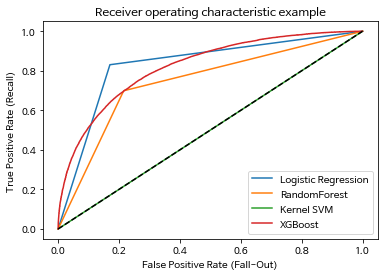

Wall time: 2min 58s


In [71]:
%%time
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3, gbm)

In [72]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [73]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.3338
Accuracy: 0.8537


In [74]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

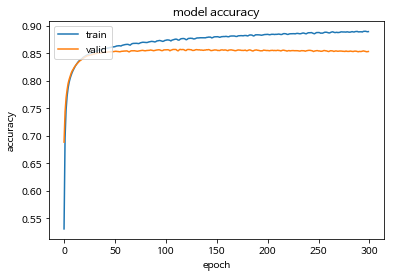

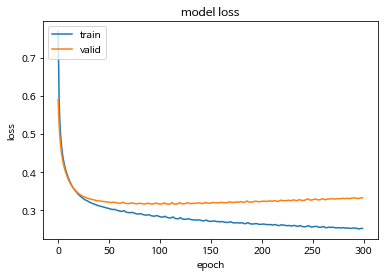

In [75]:
plot_history(history)

In [76]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train,epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.3561
Accuracy: 0.8522


In [77]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

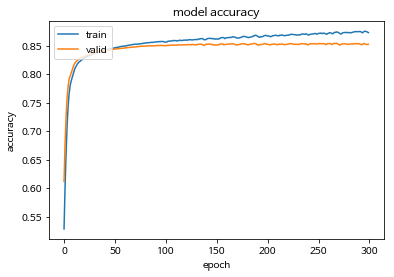

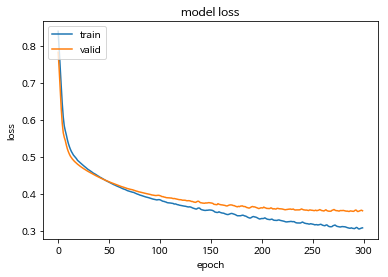

In [78]:
plot_history(history)

In [79]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name